In [26]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [27]:
env = gym.make("FrozenLake-v1", render_mode="human", is_slippery=False)
env.unwrapped

In [28]:
env.action_space

Discrete(4)

In [29]:
env.observation_space

Discrete(16)

### Temporal Difference learning basic implementation

In [70]:
import numpy as np
import gym

class td_sarsa:
    def __init__(self, env, num_episodes=10000, gamma=0.9,
                 alpha=0.1, epsilon_start=1.0, epsilon_end=0.1):
        self.env = env
        self.num_episodes = num_episodes
        self.gamma = gamma
        self.alpha = alpha

        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end

        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n

        self.Q = np.zeros((self.num_states, self.num_actions))

    def get_epsilon(self, episode):
        frac = min(1.0, episode / self.num_episodes)
        return self.epsilon_start + frac * (self.epsilon_end - self.epsilon_start)

    def get_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])

    def train(self):
        episode_returns = []

        for epi in range(1, self.num_episodes + 1):
            eps = self.get_epsilon(epi)

            state, _ = self.env.reset()   
            action = self.get_action(state, eps)
            done = False
            total_reward = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                total_reward += reward

                if done:
                    td_target = reward
                    td_error = td_target - self.Q[state, action]
                    self.Q[state, action] += self.alpha * td_error
                    break
                else:
                    next_action = self.get_action(next_state, eps)
                    td_target = reward + self.gamma * self.Q[next_state, next_action]
                    td_error = td_target - self.Q[state, action]
                    self.Q[state, action] += self.alpha * td_error

                    state, action = next_state, next_action

            episode_returns.append(total_reward)

            if self.num_episodes >= 100 and epi % (self.num_episodes // 10) == 0:
                avg_return = np.mean(episode_returns[-(self.num_episodes // 10):])
                print(f"Episode {epi}/{self.num_episodes}, "
                      f"ε={eps:.3f}, "
                      f"avg return (last {self.num_episodes//10}): {avg_return:.2f}")

        final_policy = np.argmax(self.Q, axis=1)
        return final_policy, self.Q, episode_returns


env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4")
agent = td_sarsa(
    env,
    num_episodes=20000,
    gamma=0.9,
    alpha=0.1,
    epsilon_start=1.0,
    epsilon_end=0.1
)

final_policy, Q, returns = agent.train()
print("Final Policy:", final_policy)
print("Q-values:\n", Q)
env.close()

Episode 2000/20000, ε=0.910, avg return (last 2000): 0.02
Episode 4000/20000, ε=0.820, avg return (last 2000): 0.07
Episode 6000/20000, ε=0.730, avg return (last 2000): 0.11
Episode 8000/20000, ε=0.640, avg return (last 2000): 0.21
Episode 10000/20000, ε=0.550, avg return (last 2000): 0.28
Episode 12000/20000, ε=0.460, avg return (last 2000): 0.41
Episode 14000/20000, ε=0.370, avg return (last 2000): 0.48
Episode 16000/20000, ε=0.280, avg return (last 2000): 0.63
Episode 18000/20000, ε=0.190, avg return (last 2000): 0.75
Episode 20000/20000, ε=0.100, avg return (last 2000): 0.84
Final Policy: [2 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]
Q-values:
 [[0.43686029 0.44673635 0.45161001 0.44222006]
 [0.40496646 0.         0.56032261 0.49111062]
 [0.49320038 0.6562088  0.44655485 0.55451661]
 [0.54056169 0.         0.34381239 0.28603749]
 [0.44626783 0.5051059  0.         0.4258161 ]
 [0.         0.         0.         0.        ]
 [0.         0.756795   0.         0.54486835]
 [0.         0.         0.

In [71]:
move_mapping = {
    0: "Left",
    1: "Down",
    2: "Right",
    3: "Up"
}

In [72]:
# print policy in a matrix format
policy_matrix = final_policy.reshape((4, 4))
print("Policy matrix:")
# print(policy_matrix)
for row in policy_matrix:
    print(" | ".join(move_mapping[action] for action in row))
    

Policy matrix:
Right | Right | Down | Left
Down | Left | Down | Left
Right | Down | Down | Left
Left | Right | Right | Left


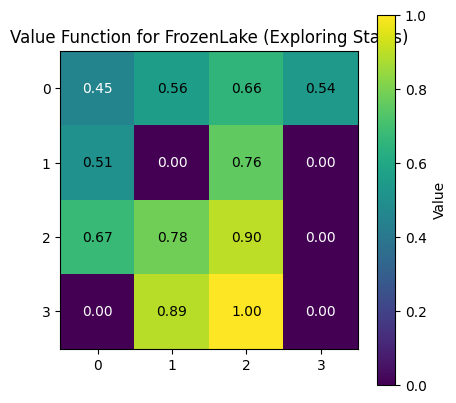

In [73]:
def plot_value_function(Q_table, env_shape, title="State-Value Function (V(s))"):
    """Assumes env_shape is a tuple like (rows, cols) for a grid environment."""
    V = np.max(Q_table, axis=1)
    V_grid = V.reshape(env_shape)
    plt.figure(figsize=(env_shape[1]*1.2, env_shape[0]*1.2)) # Adjust size based on grid
    plt.imshow(V_grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xticks(np.arange(env_shape[1]))
    plt.yticks(np.arange(env_shape[0]))
    # Add text annotations for values
    for i in range(env_shape[0]):
        for j in range(env_shape[1]):
            plt.text(j, i, f"{V_grid[i, j]:.2f}", ha="center", va="center", color="white" if V_grid[i,j] < V_grid.max()/2 else "black")
    plt.show()

plot_value_function(Q, env_shape=(4,4) , title="Value Function for FrozenLake (Exploring Starts)")